In [1]:
import os


os.chdir('../../experiments')

# print("Current working directory:", os.getcwd())

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import random


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:

directory = "../data"
files = os.listdir(directory)
files

['CustomColoredFashionMNIST', 'FashionMNIST', 'MNIST']

In [4]:
GREEN = (0, 1, 0)
RED = (1, 0, 0)
BLUE = (0, 0, 1)
train_batch_size = 64
test_batch_size = 128

fashion_mnist_classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

In [5]:
from torch.utils.data import Dataset
import random


class FD1GreenFashionMNIST(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        if self.transform:
            image = self.transform(image)
        return self.colorize(image), label

    def colorize(self, image, color=GREEN):
        color = torch.tensor(color, dtype=torch.float32)

        colored_image = image * color.view(3, 1, 1)
        return colored_image


class FD2RandomColorFashionMNIST(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        if self.transform:
            image = self.transform(image)
        return self.colorize(image), label

    def colorize(self, image):
        colors = [GREEN, RED, BLUE]
        color = random.choice(colors)
        color = torch.tensor(color, dtype=torch.float32)

        colored_image = image * color.view(3, 1, 1)
        return colored_image


class FD3EqualPartsColorFashionMNIST(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        if self.transform:
            image = self.transform(image)
        return self.colorize(image), label

    def colorize(self, image):
        colors = [GREEN, RED, BLUE]
        random.shuffle(colors)
        length = image.shape[1]
        parts = 3
        for i, color in enumerate(colors):

            color = torch.tensor(color, dtype=torch.float32)
            image[:, i * (length // parts):(i + 1) *
                  (length // parts), :] *= color.view(3, 1, 1)

        return image

In [15]:
grey_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Ensure 3 channels for input
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    #                      )  # Normalize for 3 channels
])


train_fashion_mnist = datasets.FashionMNIST(
    root=directory,
    train=True,
    download=True,
    transform=None
)
test_fashion_mnist = datasets.FashionMNIST(
    root=directory,
    train=False,
    download=True,
    transform=None
)

FD1_train_dataset = FD1GreenFashionMNIST(
    train_fashion_mnist, transform=grey_transform)
FD1_test_dataset = FD1GreenFashionMNIST(
    test_fashion_mnist, transform=grey_transform)

FD2_train_dataset = FD2RandomColorFashionMNIST(
    train_fashion_mnist, transform=grey_transform)
FD2_test_dataset = FD2RandomColorFashionMNIST(
    test_fashion_mnist, transform=grey_transform)

FD3_train_dataset = FD3EqualPartsColorFashionMNIST(
    train_fashion_mnist, transform=grey_transform)
FD3_test_dataset = FD3EqualPartsColorFashionMNIST(
    test_fashion_mnist, transform=grey_transform)

In [16]:
FD1_train_loader = DataLoader(
    FD1_train_dataset, batch_size=train_batch_size, shuffle=True)
FD1_test_loader = DataLoader(
    FD1_test_dataset, batch_size=test_batch_size, shuffle=False)

FD2_train_loader = DataLoader(
    FD2_train_dataset, batch_size=train_batch_size, shuffle=True)
FD2_test_loader = DataLoader(
    FD2_test_dataset, batch_size=test_batch_size, shuffle=False)

FD3_train_loader = DataLoader(
    FD3_train_dataset, batch_size=train_batch_size, shuffle=True)
FD3_test_loader = DataLoader(
    FD3_test_dataset, batch_size=test_batch_size, shuffle=False)

In [17]:
def show_images_from_loader(loader, classes=fashion_mnist_classes, n_images=64):

    # Get a batch of images and labels
    images, labels = next(iter(loader))

    # Select n_images from the batch
    # print(labels)
    images, labels = images[:n_images], labels[:n_images]

    # Create a grid of images
    grid = utils.make_grid(images, nrow=int(
        n_images**0.5), padding=2, normalize=True)

    plt.figure(figsize=(8, 8))
    # Convert from (C, H, W) to (H, W, C) for plotting
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title("Sample Images from Dataset")

    for i, label in enumerate(labels):
        row, col = divmod(i, int(n_images**0.5))
        plt.text(col * (grid.size(2) / n_images**0.5) + 5,
                 row * (grid.size(1) / n_images**0.5) + 5,
                 classes[label.item()],
                 color='white', fontsize=9, ha='center', bbox=dict(facecolor='black', alpha=0.6))
    plt.show()

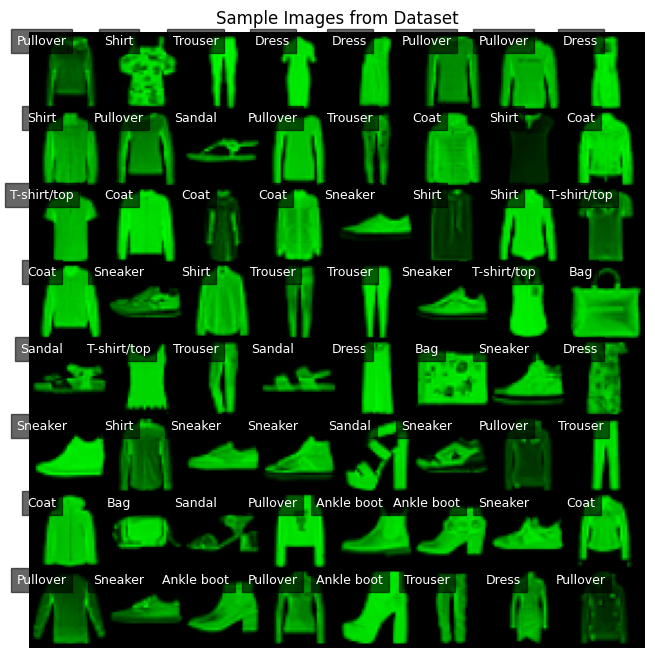

In [18]:
show_images_from_loader(FD1_train_loader)

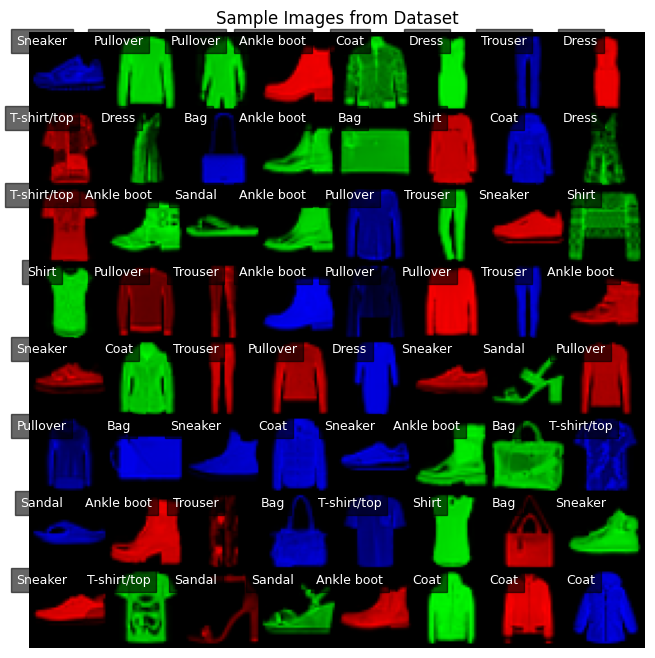

In [19]:
show_images_from_loader(FD2_train_loader)

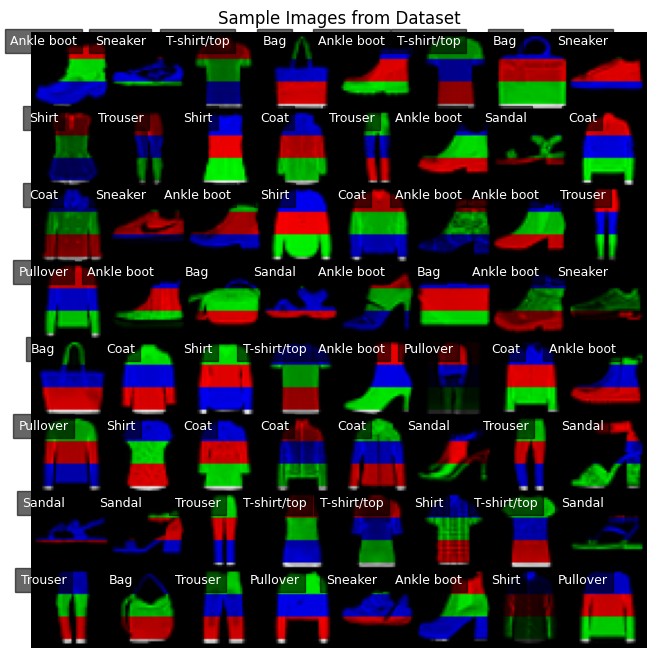

In [20]:
show_images_from_loader(FD3_train_loader)

In [21]:
from train import train, test
from cnn import _2LayerCNN, VGGInspiredCNN

In [22]:
fd1model = VGGInspiredCNN().to(device)
fd2model = VGGInspiredCNN().to(device)
fd3model = VGGInspiredCNN().to(device)
# optimizer = optim.Adam(_2LayerCNN().to(device).parameters())
criterion = nn.CrossEntropyLoss()

In [23]:
for epoch in range(1, 6):
    train(fd1model, device, FD1_train_loader,
          optim.Adam(fd1model.parameters()), epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303972
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.713762
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.772748
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.744446
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.705310
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.711021
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.706368
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.664187
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.721068
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.726362
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.758026
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.726613
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.788635
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.819322
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.794128
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.742402
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.774179
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.755105
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.632684
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.804663
Train Epoch:

In [24]:
test(fd1model, device, FD1_test_loader)
test(fd1model, device, FD2_test_loader)
test(fd1model, device, FD3_test_loader)


Test set: Average loss: 0.0133, Accuracy: 7724/10000 (77.24%)


Test set: Average loss: 0.0159, Accuracy: 4511/10000 (45.11%)


Test set: Average loss: 0.0163, Accuracy: 3934/10000 (39.34%)



In [25]:
for epoch in range(1, 6):
    train(fd2model, device, FD2_train_loader,
          optim.Adam(fd2model.parameters()), epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301541
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.727476
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.811727
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.803006
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.774862
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.779136
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.794699
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.729623
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.679905
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.662097
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.728184
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.702369
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.654716
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.677202
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.622810
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.798437
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.676583
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.663975
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.713937
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.601775
Train Epoch:

In [26]:
test(fd2model, device, FD1_test_loader)
test(fd2model, device, FD2_test_loader)
test(fd2model, device, FD3_test_loader)


Test set: Average loss: 0.0128, Accuracy: 8430/10000 (84.30%)


Test set: Average loss: 0.0128, Accuracy: 8435/10000 (84.35%)


Test set: Average loss: 0.0128, Accuracy: 8425/10000 (84.25%)



In [27]:
for epoch in range(1, 6):
    train(fd1model, device, FD3_train_loader,
          optim.Adam(fd3model.parameters()), epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.253775
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.173664
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.280078
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.323774
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.282302
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.227289
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.236770
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.249898
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.212705
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.230504
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.242899
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.133993
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.287575
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.223562
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.271563
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.180105
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.296995
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.251652
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.197257
Train Epoch: 2 [57600/60000 (96%)]	Loss: 2.260090
Train Epoch:

In [28]:
test(fd3model, device, FD1_test_loader)
test(fd3model, device, FD2_test_loader)
test(fd3model, device, FD3_test_loader)


Test set: Average loss: 0.0182, Accuracy: 1000/10000 (10.00%)


Test set: Average loss: 0.0182, Accuracy: 1000/10000 (10.00%)


Test set: Average loss: 0.0182, Accuracy: 1000/10000 (10.00%)

